In [1]:
import os
import cv2
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

In [2]:
# Custom dataset for grayscale image pairs (original, filtered)
class PatchDataset(Dataset):
    def __init__(self, original_dir, filtered_dir, patch_size=11):
        self.original_files = sorted([
            os.path.join(original_dir, f) for f in os.listdir(original_dir)
            if f.lower().endswith(('.jpg', '.jpeg', '.png'))
        ])
        self.filtered_files = sorted([
            os.path.join(filtered_dir, f) for f in os.listdir(filtered_dir)
            if f.lower().endswith(('.jpg', '.jpeg', '.png'))
        ])
        assert len(self.original_files) == len(self.filtered_files), "Mismatch in number of original and filtered images"

        self.patch_size = patch_size
        self.half = patch_size // 2
        self.patch_indices = []

        # Precompute all valid patch center positions
        for i, path in enumerate(self.original_files):
            img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
            if img is None:
                continue
            h, w = img.shape
            for r in range(self.half, h - self.half):
                for c in range(self.half, w - self.half):
                    self.patch_indices.append((i, r, c))

    def __len__(self):
        return len(self.patch_indices)

    def __getitem__(self, idx):
        i, r, c = self.patch_indices[idx]
        orig = cv2.imread(self.original_files[i], cv2.IMREAD_GRAYSCALE).astype(np.float32) / 127.5 - 1.0
        filt = cv2.imread(self.filtered_files[i], cv2.IMREAD_GRAYSCALE).astype(np.float32) / 127.5 - 1.0
        patch = orig[r - self.half:r + self.half + 1, c - self.half:c + self.half + 1].flatten()
        target = filt[r, c]
        return torch.tensor(patch, dtype=torch.float32), torch.tensor(target, dtype=torch.float32)


In [3]:
# Feedforward neural network model
class FFANN(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(121, 128),      # 11x11 = 121 input neurons
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 1),
            nn.Tanh()                # Output in [-1, 1]
        )

    def forward(self, x):
        return self.model(x)


In [6]:
# Set device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Parameters
patch_size = 11
batch_size = 512
num_epochs = 20
learning_rate = 0.01

# Load dataset
dataset = PatchDataset("pixelate_org", "pixelate_fil", patch_size=patch_size)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Initialize model, loss, optimizer
model = FFANN().to(device)
criterion = nn.L1Loss()  # MAE
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, (inputs, targets) in enumerate(dataloader):
        inputs = inputs.to(device)
        targets = targets.to(device)

        optimizer.zero_grad()
        outputs = model(inputs).squeeze()
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if (i + 1) % 100 == 0:
            print(f"Epoch {epoch+1}, Batch {i+1}, Loss: {running_loss / 100:.4f}")
            running_loss = 0.0

print("✅ Training complete.")

# Save model weights
torch.save(model.state_dict(), "pixelate_model_weights.pth")
print("✅ Model saved as pixelate_model_weights.pth")

Epoch 1, Batch 100, Loss: 0.0796
Epoch 2, Batch 100, Loss: 0.0564


KeyboardInterrupt: 

C:\Users\merte\AppData\Local\Temp\ipykernel_19952\1511652558.py:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("pixelate_model_weights.pt

✅ ANN output saved: ann_output_pixelate_img3.png


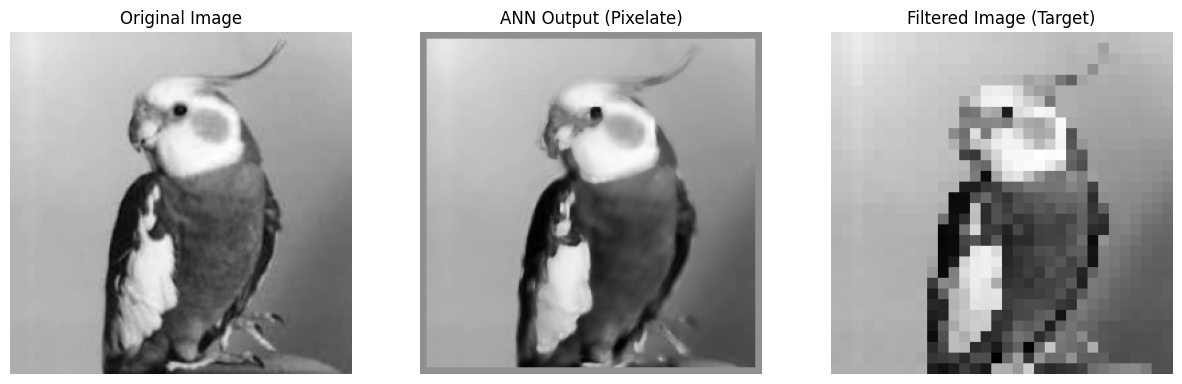

In [5]:
import matplotlib.pyplot as plt

# File paths
img_path = "pixelate_org/image.jpeg"
filtered_path = "pixelate_fil/image.png"

# Load images (grayscale)
original_img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
filtered_img = cv2.imread(filtered_path, cv2.IMREAD_GRAYSCALE)

h, w = original_img.shape

# Normalize [-1, 1]
orig_norm = original_img.astype(np.float32) / 127.5 - 1.0
predicted = np.zeros_like(orig_norm)

# Load the model
model = FFANN().to(device)
model.load_state_dict(torch.load("pixelate_model_weights.pth"))
model.eval()

# 11x11 patch prediction
patch_size = 11
half = patch_size // 2

with torch.no_grad():
    for r in range(half, h - half):
        for c in range(half, w - half):
            patch = orig_norm[r - half:r + half + 1, c - half:c + half + 1]
            patch = patch.flatten()
            patch_tensor = torch.from_numpy(patch).float().unsqueeze(0).to(device)
            output = model(patch_tensor)
            predicted[r, c] = output.item()

# Denormalize [0, 255]
predicted_denorm = ((predicted + 1.0) * 127.5).astype(np.uint8)

# Save
ann_output_path = "ann_output_pixelate_img3.png"
cv2.imwrite(ann_output_path, predicted_denorm)
print(f"✅ ANN output saved: {ann_output_path}")

# Visualize
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(original_img, cmap="gray")
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(predicted_denorm, cmap="gray")
plt.title("ANN Output (Pixelate)")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(filtered_img, cmap="gray")
plt.title("Filtered Image (Target)")
plt.axis("off")

plt.show()